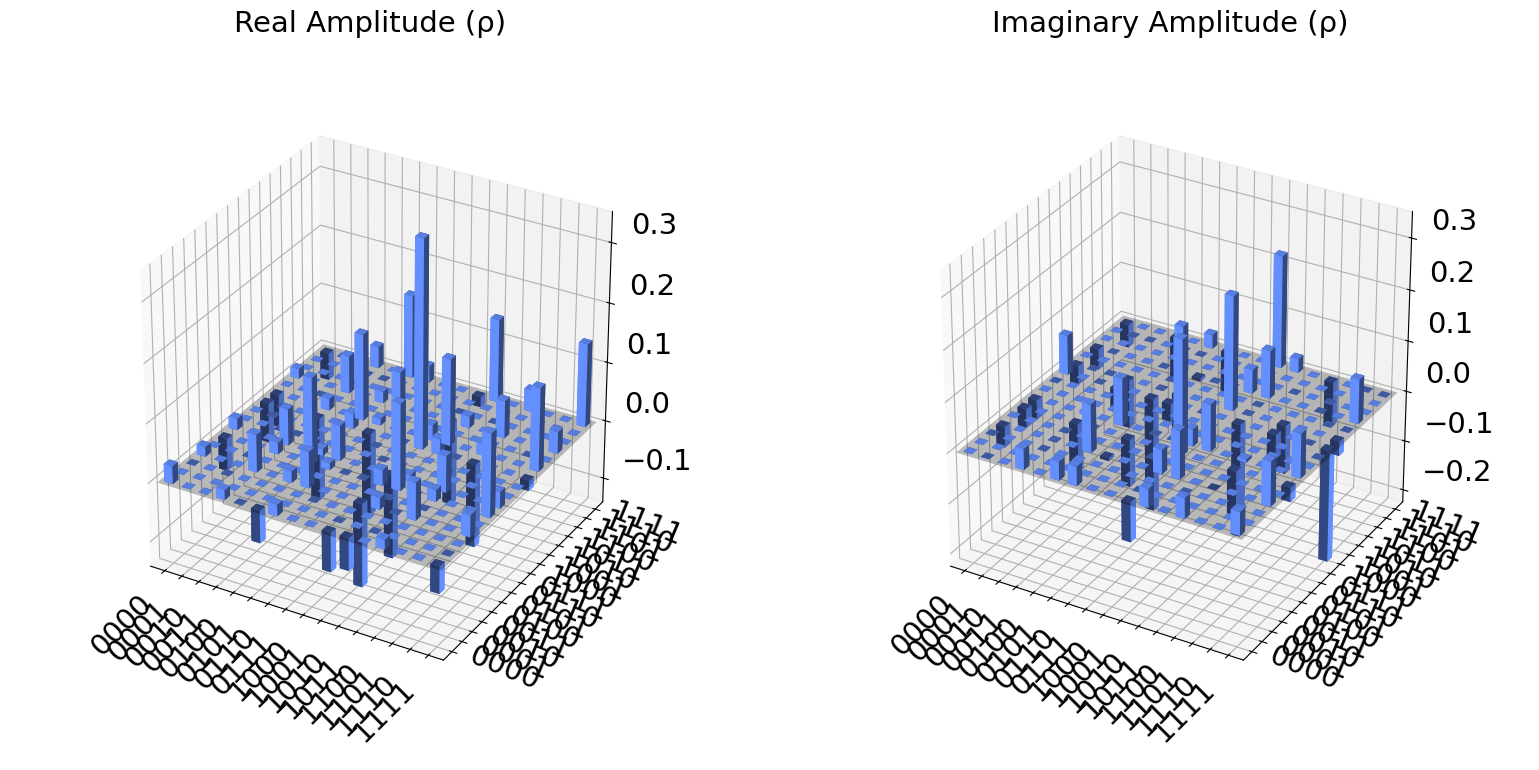

In [1]:
import density_generator
from qiskit.visualization import plot_state_city
from importlib import reload
import pandas as pd
import numpy as np
reload(density_generator)

pd.options.display.float_format = "{:,.3f}".format

n = 4
a_x=1
h_z=0.1


model = density_generator.IsingQuantumState(n=n, a_x=a_x, h_z=h_z)
rho, rho_delta = model.generate_density_matrices_with_perturbation()

plot_state_city(rho)
#print(pd.DataFrame(rho))

In [2]:
DEBUG = True
def compute_tqfi_bounds(rho, rho_delta, m, delta):
    """
    Compute the Truncated Quantum Fisher Information (TQFI) bounds.

    This method follows the approach from the theoretical framework:
    1. Perform eigenvalue decomposition of rho.
    2. Truncate to the m-largest eigenvalues (principal components).
    3. Compute truncated and generalized fidelities (L R).
    4. Estimate the lower and upper bounds of TQFI.

    Parameters:
    - rho: Density matrix at parameter theta.
    - rho_delta: Density matrix at parameter theta + delta.
    - m: Truncation parameter for principal components.
    - delta: Small shift in parameter for derivative approximation.

    Returns:
    - lower_tqfi: Lower bound of TQFI.
    - upper_tqfi: Upper bound of TQFI.
    """
    # Step 1: Eigenvalue decomposition (linalg.eigh returns them in ascending order)
    eigvals, eigvecs = np.linalg.eigh(rho)

    idx = (np.argsort(eigvals))[::-1]  # Descending order
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

    # Step 2: Truncate to m-largest eigenvalues/eigenvectors
    eigvals_trunc = eigvals[:m]
    eigvecs_trunc = eigvecs[:, :m]

    if DEBUG:
        print(eigvals_trunc)

        
    # Construct the truncated density matrix
    rho_trunc = sum(
        eigvals_trunc[i] * np.outer(eigvecs_trunc[:, i], eigvecs_trunc[:, i].conj())
        for i in range(m)
    )

    return rho_trunc


    # Step 3: Compute truncated fidelity (Fidelity between truncated rho and rho_delta)
    fidelity_truncated = np.real(np.trace(np.dot(rho_trunc, rho_delta)))

    # Generalized fidelity incorporates truncation errors
    fidelity_generalized = fidelity_truncated + np.sqrt(
        max(0, (1 - np.trace(rho_trunc)) * (1 - np.trace(rho_delta)))
    )

    # Step 4: Compute TQFI bounds using fidelity definitions
    lower_tqfi = 8 * (1 - fidelity_generalized) / (delta**2)
    upper_tqfi = 8 * (1 - fidelity_truncated) / (delta**2)

    # Intermediate results for debugging
    print(f"Fidelity (Truncated): {fidelity_truncated}")
    print(f"Fidelity (Generalized): {fidelity_generalized}")

    return lower_tqfi, upper_tqfi



In [3]:
res = compute_tqfi_bounds(rho = rho, 
                    rho_delta = rho_delta,
                    m = 1,        
                    delta = 0.01)

[1.]


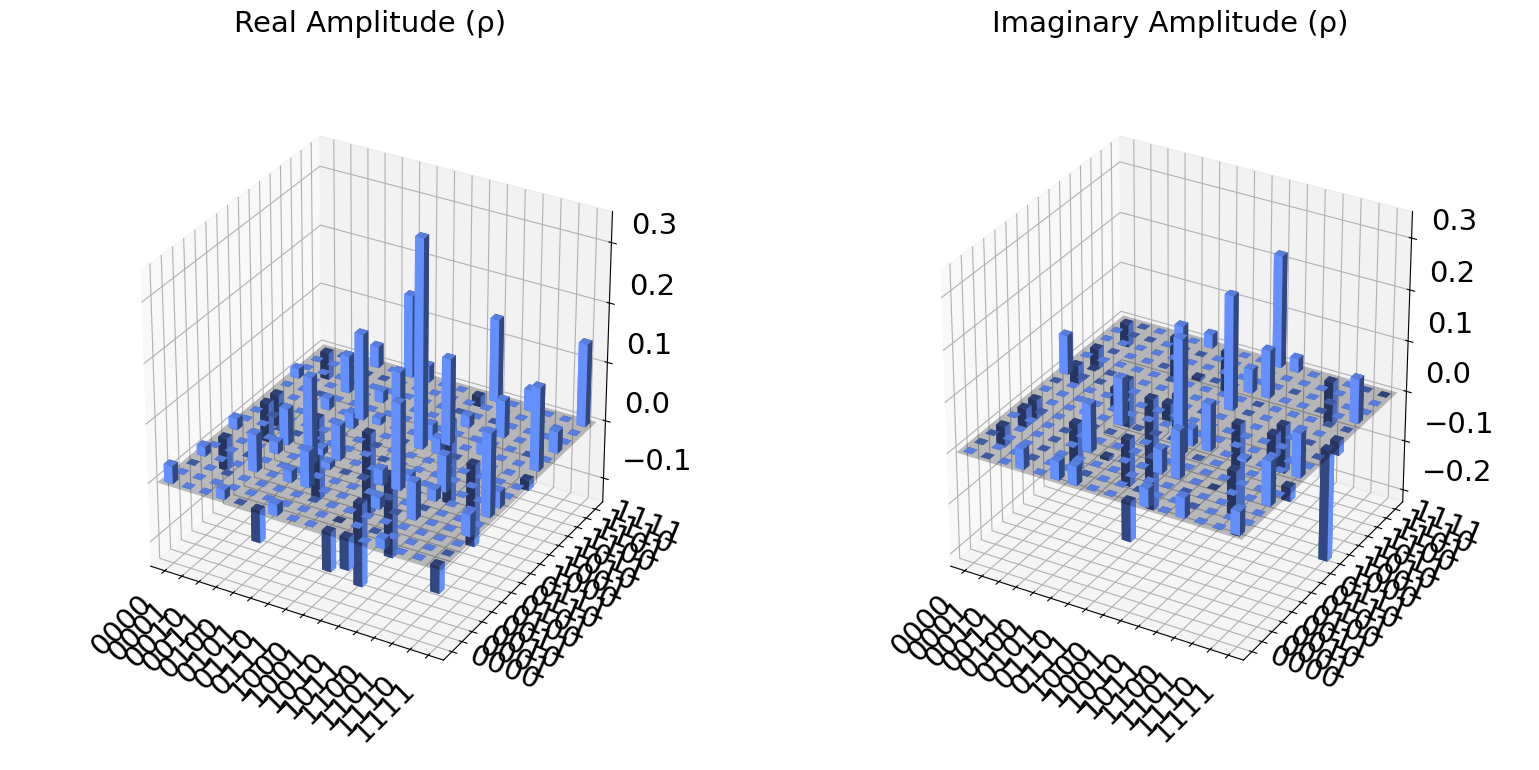

In [4]:
plot_state_city(res)

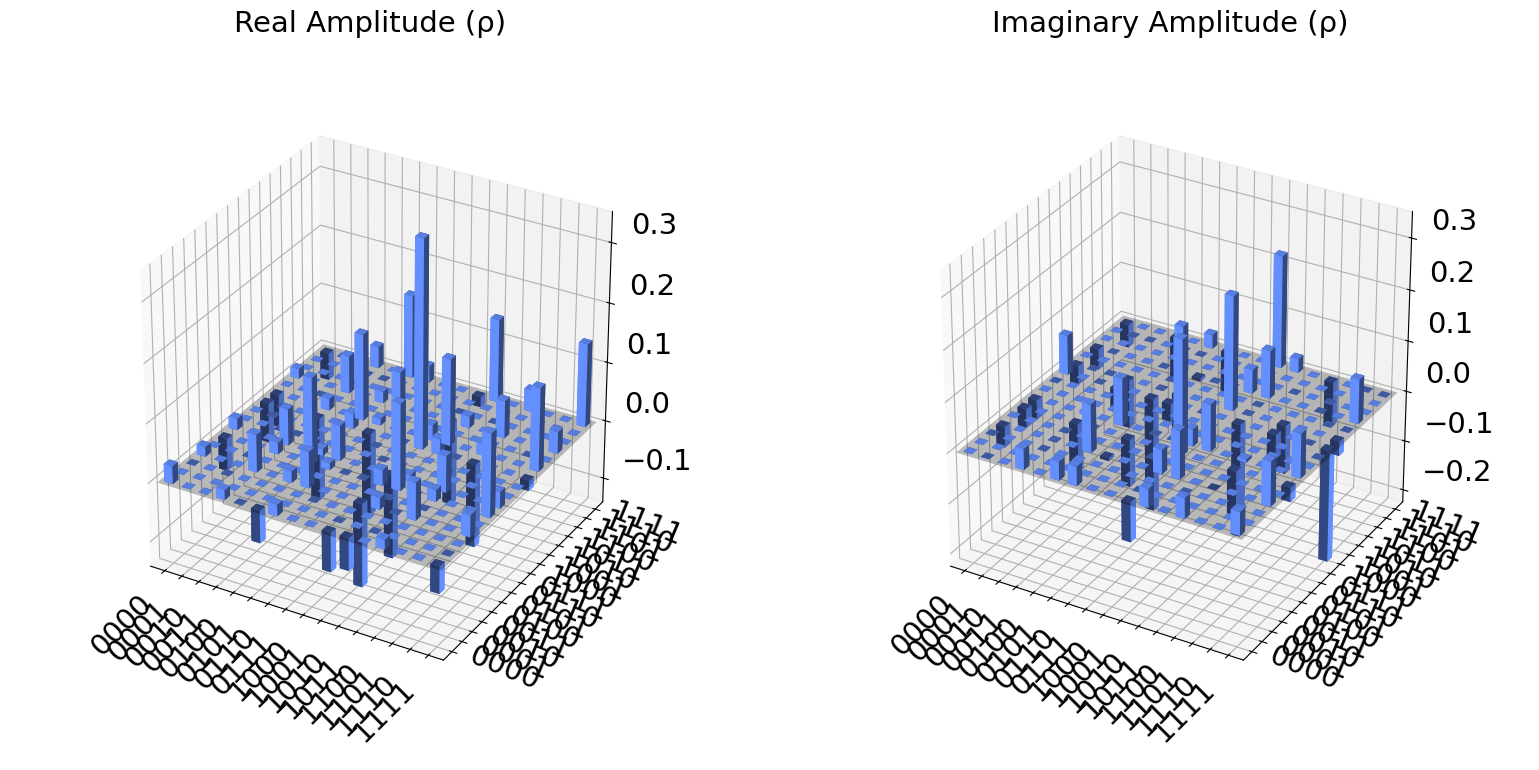

In [5]:
plot_state_city(rho)

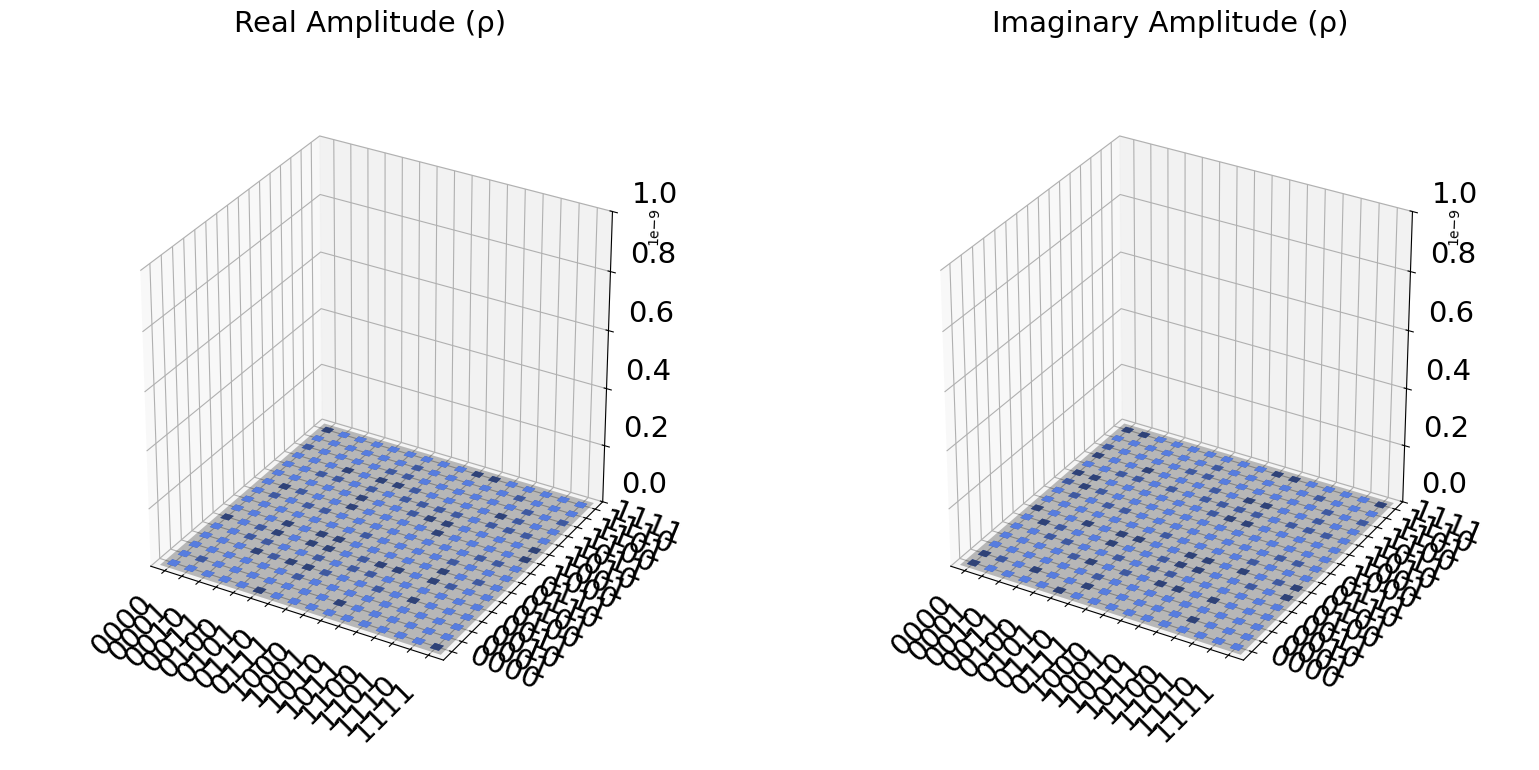

In [6]:
plot_state_city(res - rho)

In [7]:
print(f"maximum real: {np.max(np.abs(np.real(res - rho)))}")
print(f"maximum imaginary: {np.max(np.abs(np.imag(res - rho)))}")

maximum real: 5.551115123125783e-17
maximum imaginary: 8.326672684688674e-17


In [8]:
from qiskit.quantum_info import DensityMatrix, partial_trace

rho_reduced = partial_trace(rho, [n-1] ).data


In [9]:
np.real(np.trace(rho @ rho))

1.0000000000000002

In [10]:
np.real(np.trace(rho_reduced @ rho_reduced))


0.5807347124269138

In [11]:
#help(DensityMatrix)

In [12]:
import qutip

In [13]:
# explicitly tell qutip come e fatto sto sistema
d = [[2 for i in range(n)],[2 for i in range(n)]]
rho_qutip = qutip.Qobj(rho, dims=d)  
rho_qutip

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.02986632+4.88221379e-19j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j  0.01640162+4.03623107e-02j
   0.        -0.00000000e+00j -0.0548576 +3.67787109e-02j
   0.01919223+3.75770078e-02j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j -0.06650009-7.77893717e-02j
  -0.0548576 +3.67787109e-02j  0.        -0.00000000e+00j
   0.01640162+4.03623107e-02j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j -0.04587037+4.57830749e-02j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        -0.00000000e+00j
  -0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        -0.00000000e+00j  0.        +0.00000000e+00j
  -0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.       

In [14]:
#help(ptrace)
pd.DataFrame(rho)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.030+0.000j,0.000-0.000j,0.000-0.000j,0.016+0.040j,0.000-0.000j,-0.055+0.037j,0.019+0.038j,0.000-0.000j,0.000-0.000j,-0.067-0.078j,-0.055+0.037j,0.000-0.000j,0.016+0.040j,0.000-0.000j,0.000-0.000j,-0.046+0.046j
1,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j
2,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j
3,0.016-0.040j,-0.000+0.000j,-0.000+0.000j,0.064-0.000j,-0.000+0.000j,0.020+0.094j,0.061-0.005j,-0.000+0.000j,-0.000+0.000j,-0.142+0.047j,0.020+0.094j,-0.000+0.000j,0.064-0.000j,-0.000+0.000j,-0.000+0.000j,0.037+0.087j
4,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j
5,-0.055-0.037j,0.000+0.000j,0.000+0.000j,0.020-0.094j,0.000+0.000j,0.146+0.000j,0.011-0.093j,0.000+0.000j,0.000+0.000j,0.026+0.225j,0.146+0.000j,0.000+0.000j,0.020-0.094j,0.000+0.000j,0.000+0.000j,0.141-0.028j
6,0.019-0.038j,-0.000+0.000j,-0.000+0.000j,0.061+0.005j,-0.000+0.000j,0.011+0.093j,0.060+0.000j,-0.000+0.000j,-0.000+0.000j,-0.141+0.034j,0.011+0.093j,-0.000+0.000j,0.061+0.005j,-0.000+0.000j,-0.000+0.000j,0.028+0.087j
7,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j
8,0.000+0.000j,0.000+0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000-0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j,0.000+0.000j,-0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000-0.000j
9,-0.067+0.078j,0.000+0.000j,0.000+0.000j,-0.142-0.047j,0.000+0.000j,0.026-0.225j,-0.141-0.034j,0.000+0.000j,0.000+0.000j,0.351+0.000j,0.026-0.225j,0.000+0.000j,-0.142-0.047j,0.000+0.000j,0.000+0.000j,-0.017-0.221j


In [15]:
rho_qutip

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.02986632+4.88221379e-19j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j  0.01640162+4.03623107e-02j
   0.        -0.00000000e+00j -0.0548576 +3.67787109e-02j
   0.01919223+3.75770078e-02j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j -0.06650009-7.77893717e-02j
  -0.0548576 +3.67787109e-02j  0.        -0.00000000e+00j
   0.01640162+4.03623107e-02j  0.        -0.00000000e+00j
   0.        -0.00000000e+00j -0.04587037+4.57830749e-02j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        -0.00000000e+00j
  -0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        -0.00000000e+00j  0.        +0.00000000e+00j
  -0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.       

In [16]:
rho_qutip.ptrace(sel=list(range(n-1)))

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.02986632+4.88221379e-19j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.01919223+3.75770078e-02j
   0.        +0.00000000e+00j -0.0548576 +3.67787109e-02j
   0.01640162+4.03623107e-02j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.06355417-3.73077856e-19j
   0.01957792+9.43340181e-02j  0.        +0.00000000e+00j
  -0.14164678+4.71509771e-02j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.03668221+8.71332932e-02j]
 [ 0.        +0.00000000e+00j  0.01957792-9.43340181e-02j
   0.14605181+1.44609054e-18j  0.        +0.00000000e+00j
   0.02635219+2.24772467e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.14063271-2.76062297e-02j]
 [ 0.01919223-3.75770078e-02j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.0596114 +1.22453155e-18j
   0.        +0.00000000e+00j  0.01102226+9.26545391e-02j
   0.06132254+5.30

In [17]:
rho_reduced

array([[ 0.02986632+4.88221379e-19j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.01640162+4.03623107e-02j,
         0.        +0.00000000e+00j, -0.0548576 +3.67787109e-02j,
         0.01919223+3.75770078e-02j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.3506776 +9.46268116e-19j,
         0.02635219-2.24772467e-01j,  0.        +0.00000000e+00j,
        -0.14164678-4.71509771e-02j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, -0.01711133-2.21413509e-01j],
       [ 0.        +0.00000000e+00j,  0.02635219+2.24772467e-01j,
         0.14605181-9.05474369e-19j,  0.        +0.00000000e+00j,
         0.01957792-9.43340181e-02j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.14063271-2.76062297e-02j],
       [ 0.01640162-4.03623107e-02j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.06355417-3.73077856e-19j,
         0.        +0.00000000e+00j,  0.01957792+9.43340181e-02j,
       

In [18]:
rho_reduced_qutip = rho_qutip.ptrace(sel=list(range(n-1))).full()

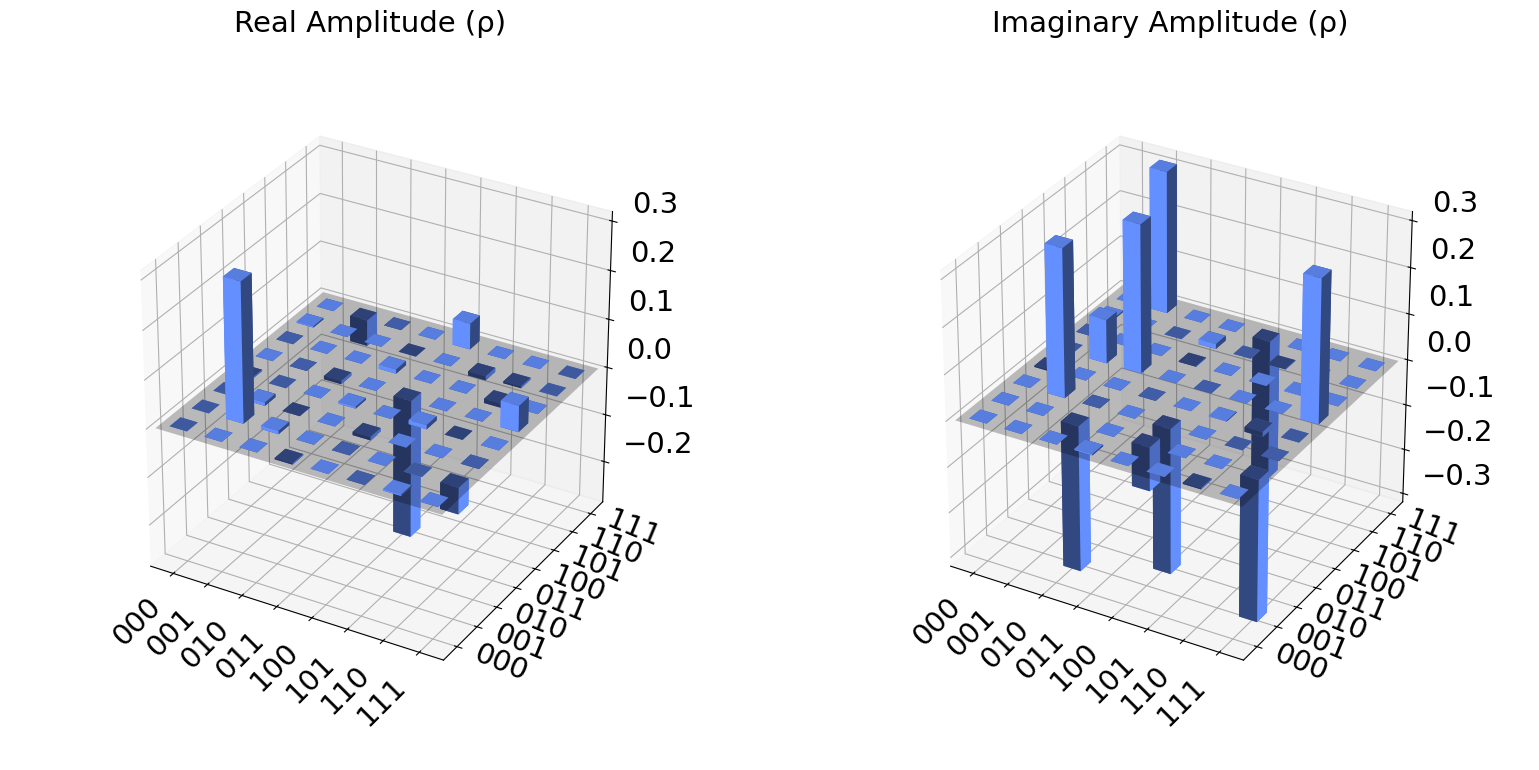

In [19]:
plot_state_city(rho_reduced - rho_reduced_qutip)